In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sys
import datetime
from matplotlib import colors
sys.path.insert(0,'/home/janssens/scripts/pp3d')
from functions import getRad, lowPass, mean_mask
import warnings
warnings.filterwarnings("ignore")

In [63]:
lp = '/scratch-shared/janssens/eurec4a_balanced_100km'
sp = lp+'/figs'

klp = 4
qlc = 1e-7

ds = xr.open_dataset(lp+'/cape2d.001.nc')
ds1 = xr.open_dataset(lp+'/profiles.001.nc')
ds3 = xr.open_dataset(lp+'/fielddump.001.nc')

# time  = np.ma.getdata(ds.variables['time'][:]) / 3600
# xf    = np.ma.getdata(ds.variables['xt'][:]) # Cell centres (f in mhh)
# xh    = np.ma.getdata(ds.variables['xm'][:]) # Cell edges (h in mhh)
# yf    = np.ma.getdata(ds.variables['yt'][:]) # Cell centres (f in mhh)
# yh    = np.ma.getdata(ds.variables['ym'][:]) # Cell edges (h in mhh)

# time3 = np.ma.getdata(ds3.variables['time'][:]) / 3600

extent = np.array([ds['xt'].min().values, ds['xt'].max().values, ds['xt'].min().values, ds['xt'].max().values])/1000

circ_mask = np.zeros((ds['xt'].size,ds['xt'].size))
rad = getRad(circ_mask)
circ_mask[rad<=klp] = 1
ds

# # Calculate column-averaged density
# zf = ds1['zt'][:].data
# rhob = ds1['rhobf'][0,:].data
# rho0 = np.trapz(rhob,zf)

<xarray.Dataset>
Dimensions:   (xt: 1024, xm: 1024, yt: 1024, ym: 1024, time: 288)
Coordinates:
  * xt        (xt) float32 50.0 150.0 250.0 ... 1.022e+05 1.022e+05 1.024e+05
  * xm        (xm) float32 0.0 100.0 200.0 ... 1.021e+05 1.022e+05 1.023e+05
  * yt        (yt) float32 50.0 150.0 250.0 ... 1.022e+05 1.022e+05 1.024e+05
  * ym        (ym) float32 0.0 100.0 200.0 ... 1.021e+05 1.022e+05 1.023e+05
  * time      (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-02
Data variables: (12/20)
    dcape     (time, yt, xt) float32 ...
    dscape    (time, yt, xt) float32 ...
    dcin      (time, yt, xt) float32 ...
    dscin     (time, yt, xt) float32 ...
    dcintot   (time, yt, xt) float32 ...
    capemax   (time, yt, xt) float32 ...
    ...        ...
    qlcb      (time, yt, xt) float32 ...
    lwp       (time, yt, xt) float32 ...
    rwp       (time, yt, xt) float32 ...
    twp       (time, yt, xt) float32 ...
    cldtop    (time, yt, xt) float32 ...
    surfprec  (time, yt, xt) float32 ...
Attributes:
    title:    cape.x000y000.001.nc
    history:  Created on 20230225 at 011901.793
    Source:   DALES 4.4 git: 4.3-rc.2-58-g37e793-dirty
    Author:

Text(0, 0.5, 'Total Water Path fluctuation [kg/kg/m$^2$]')

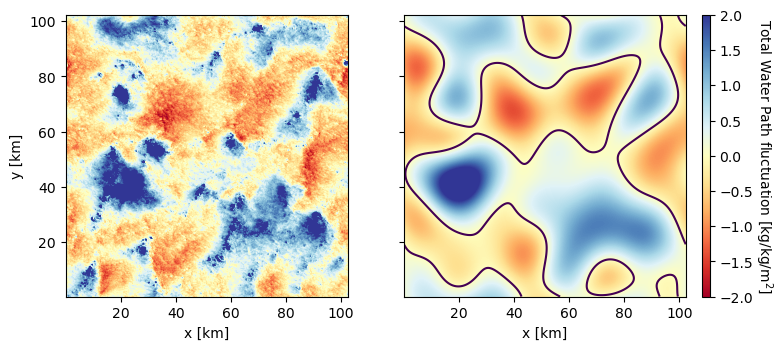

In [15]:
#%% Plot twp, twppf and clouds at a single time step

tPlot = '2020-02-01 23:00:00'


# Albedo
qli = ds['lwp'].sel(time=tPlot, method='nearest')
tau = 0.19*qli**(5./6)*7e7**(1/3)
alb = tau/(6.8+tau)
# alb = qli.copy()
# alb[qli<qlc] = 0
# alb[qli>=qlc] = 1

# TWP fluctuation
twpp = ds['twp'].sel(time=tPlot)
twpp -= np.median(twpp)

# Low-pass filtered TWP fluctuation
twppf = lowPass(twpp.values, circ_mask)

fig,axs = plt.subplots(ncols=2,figsize=(8,4),sharey=True)
sc = axs[0].imshow(twpp,extent=extent,vmin=-2,vmax=2,cmap='RdYlBu')
axs[0].set_xlabel('x [km]')
axs[0].set_ylabel('y [km]')

axs[1].imshow(twppf,extent=extent,vmin=-2,vmax=2,cmap='RdYlBu')
axs[1].contour(twppf,levels=[0],extent=extent,origin='upper')
axs[1].set_xlabel('x [km]')

# axs[2].contour(twppf,levels=[0],extent=extent,origin='upper',colors='white')
# axs[2].imshow(alb,extent=extent,vmin=0,vmax=1,cmap='gist_gray')
# axs[2].set_xlabel('x [km]')

pos1 = axs[1].get_position()
cbax = fig.add_axes([.92, pos1.ymin, 0.01, pos1.height])
# cbax = fig.add_axes([1, 0.1, 0.02, 0.85])
# cbax = fig.add_axes([-0.06, 0.1, 0.02, 0.85])
cb = fig.colorbar(sc, cax=cbax)
cb.ax.set_ylabel(r"Total Water Path fluctuation [kg/kg/m$^2$]", rotation=270, labelpad=15) #-65
# plt.tight_layout()
# plt.savefig(sp+'/twpfluct.pdf',bbox_inches='tight',dpi=300)

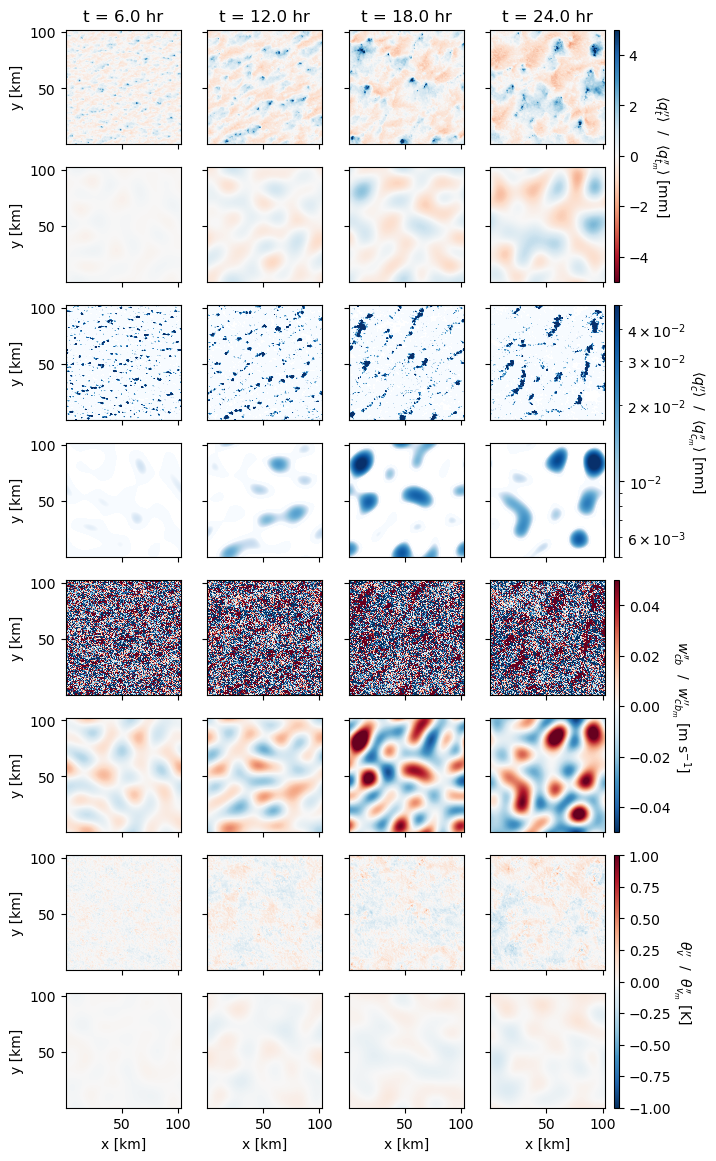

In [61]:
#%% Plot the time evolution of twpp
fq=1e3
t0 = '2020-02-01 00:00:00'
t0 = datetime.datetime.strptime(t0,'%Y-%m-%d %H:%M:%S')
tPlot = np.linspace(6,24,4)

fig,axs = plt.subplots(ncols=len(tPlot),nrows=4*2,figsize=(1.75*len(tPlot),1.75*4*2),
                       sharex=True,sharey=True,squeeze=False)

for j in range(len(tPlot)):

    # Select ds['twp'] at time tPlot[j] after t0:
    twpp = ds['twp'].sel(time=t0 + datetime.timedelta(hours=tPlot[j]), method='nearest')
    twpp -= np.mean(twpp)
    twppf = lowPass(twpp.values, circ_mask)
    
    # cm = np.ma.getdata(ds.variables['cldtop'][it,:,:])
    # cm = np.zeros(qli.shape)
    # cm[qli<qlc] = 0
    # cm[qli>=qlc] = 1
    lwp = ds['lwp'].sel(time=t0 + datetime.timedelta(hours=tPlot[j]), method='nearest')
    lwpp = lwp - np.mean(lwp)
    lwppf = lowPass(lwpp.values, circ_mask)
    
    wcb = ds['wcb'].sel(time=t0 + datetime.timedelta(hours=tPlot[j]), method='nearest')
    wcbf = lowPass(wcb.values, circ_mask)

    thvp_cl = ds3['buoy'].sel(time=t0 + datetime.timedelta(hours=tPlot[j]), zt=900, method='nearest')
    thvpf_cl = lowPass(thvp_cl.values, circ_mask)

#     cf = np.count_nonzero(cm) / cm.size
    
    # mask_moist = np.zeros(twpp.shape)
    # mask_moist[twppf>0] = 1
    
#     mask_lwppf = np.zeros(lwppf.shape)
#     mask_lwppf[lwppf>0] = 1
    
#     mask_moist_lwppf = mask_moist*mask_lwppf
#     cmqlpf = np.count_nonzero(mask_moist_lwppf) / cm.size
    
# #     buoycb = np.ma.getdata(ds.variables['buoycb'][it,:,:])
# #     rwp = np.ma.getdata(ds.variables['rwp'][it,:,:])

# #     it3 = np.argmin(abs(tPlot[j]-time3))
# #     thlp = np.ma.getdata(ds3.variables['thl'][it3,0,:,:])
# #     thlp = thlp - np.mean(thlp)

    sc1 = axs[0,j].imshow(twpp, extent=extent,vmin=-5, vmax=5, cmap='RdBu')
    sc11 = axs[1,j].imshow(twppf, extent=extent,vmin=-5, vmax=5, cmap='RdBu')
    
    sc2 = axs[2,j].imshow(lwp , extent=extent,cmap='Blues', norm=colors.LogNorm(vmin=0.005, vmax=0.05))
    sc21 = axs[3,j].imshow(lwppf , extent=extent,cmap='Blues', norm=colors.LogNorm(vmin=0.005, vmax=0.05))

    sc3 = axs[4,j].imshow(wcb , extent=extent, vmin=-0.05, vmax=0.05, cmap='RdBu_r')
    sc31 = axs[5,j].imshow(wcbf , extent=extent,vmin=-0.05, vmax=0.05, cmap='RdBu_r')

    sc4 = axs[6,j].imshow(thvp_cl , extent=extent,vmin=-1, vmax=1, cmap='RdBu_r')
    sc41 = axs[7,j].imshow(thvpf_cl , extent=extent,vmin=-1, vmax=1, cmap='RdBu_r')
    
    
    axs[-1,j].set_xlabel('x [km]')
    axs[0,j].set_title('t = %.1f hr'%tPlot[j])
    if j == 0:
        for i in range(8):
            axs[i,j].set_ylabel('y [km]')
        
    if j == len(tPlot)-1:
        pos1 = axs[0,j].get_position()
        pos11 = axs[1,j].get_position()
        cbax1 = fig.add_axes([.91, pos11.ymin, 0.0075, pos1.ymax-pos11.ymin])
        cb1 = fig.colorbar(sc1, cax=cbax1)
        cb1.ax.set_ylabel(r"$\langle q_t''\rangle$  /  $\langle q_{t_m}''\rangle $ [mm]", rotation=270, labelpad=15)

        pos2 = axs[2,j].get_position()
        pos21 = axs[3,j].get_position()
        cbax2 = fig.add_axes([.91, pos21.ymin, 0.0075, pos2.ymax-pos21.ymin])
        cb2 = fig.colorbar(sc2, cax=cbax2)
        cb2.ax.set_ylabel(r"$\langle q_c''\rangle$  /  $\langle q_{c_m}''\rangle$ [mm]", rotation=270, labelpad=15)

        pos3 = axs[4,j].get_position()
        pos31 = axs[5,j].get_position()
        cbax3 = fig.add_axes([.91, pos31.ymin, 0.0075, pos3.ymax-pos31.ymin])
        cb3 = fig.colorbar(sc3, cax=cbax3)
        cb3.ax.set_ylabel(r"$ w_{cb}''$  /  $w_{cb_m}''$ [m s$^{-1}$]", rotation=270, labelpad=15)

        pos4 = axs[6,j].get_position()
        pos41 = axs[7,j].get_position()
        cbax4 = fig.add_axes([.91, pos41.ymin, 0.0075, pos4.ymax-pos41.ymin])
        cb4 = fig.colorbar(sc4, cax=cbax4)
        cb4.ax.set_ylabel(r"$\theta_v''$  /  $\theta_{v_m}''$ [K]", rotation=270, labelpad=15)
        
plt.savefig(sp+'/twp_cld_overlap.pdf', bbox_inches='tight',dpi=300)


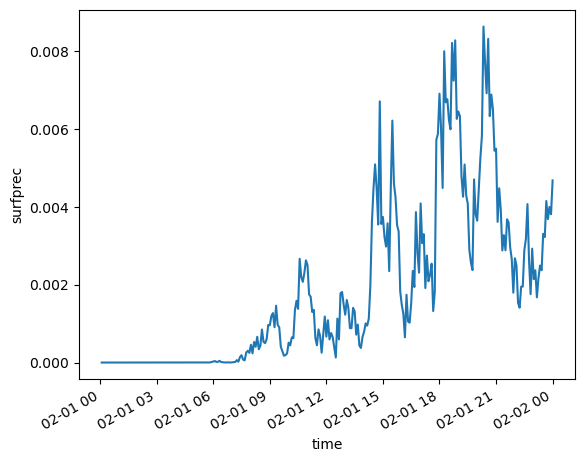

In [66]:
(3600*ds['surfprec']).mean(dim=['xt','yt']).plot()

/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
No handles with labels found to put in legend.


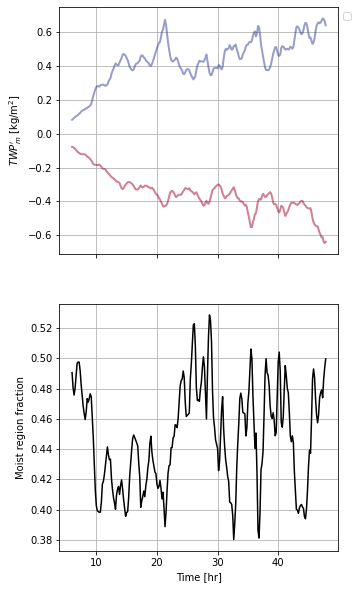

In [14]:
#%% Plot time evolution of twp, for a number of simulations

alpha=0.5
lw=2
col_moist = plt.cm.RdYlBu(0.99)
col_dry = plt.cm.RdYlBu(0)

tmin = 6.
tmax = 48.

itpltmin = np.where(time>=tmin)[0][0]
itpltmax = np.where(time<tmax)[0][-1]+1
plttime_var = np.arange(itpltmin,itpltmax,1)

fig, axs = plt.subplots(nrows=2,figsize=(5,10),sharex=True)

twppf_moist = np.zeros(len(plttime_var))
twppf_dry = np.zeros(len(plttime_var))
frac_moist = np.zeros(len(plttime_var))
for j in range(len(plttime_var)):
    twpp = np.ma.getdata(ds.variables['twp'][plttime_var[j],:,:])
    twpp -= np.mean(twpp)
    twppf = lowPass(twpp, circ_mask)
    mask_moist = np.zeros(twppf.shape)
    mask_moist[twppf > 0] = 1
    mask_dry = 1 - mask_moist
    frac_moist[j] = np.sum(mask_moist) / np.size(mask_moist)

    twppf_moist[j] = mean_mask(twppf, mask_moist)
    twppf_dry[j] = mean_mask(twppf, mask_dry)

axs[0].plot(time[plttime_var],twppf_moist,c=col_moist,lw=lw,alpha=alpha)
axs[0].plot(time[plttime_var],twppf_dry,c=col_dry,lw=lw,alpha=alpha)
axs[1].set_xlabel('Time [hr]')
axs[0].set_ylabel(r"$TWP_m'$ [kg/m$^2$]")
axs[0].legend(loc='upper left',bbox_to_anchor=(1,1))
axs[0].grid()

axs[1].plot(time[plttime_var], frac_moist, c='k')
axs[1].set_ylabel('Moist region fraction')
axs[1].grid()
plt.savefig(sp+'/twp_evo.pdf',bbox_inches='tight')

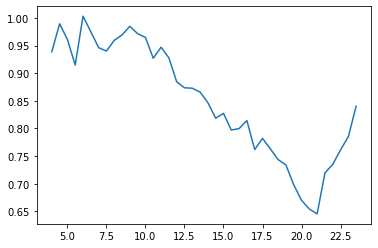

In [7]:
fq=1e3
tPlot = np.arange(4,24,0.5)

cmqlpf = np.zeros(len(tPlot))
cmqlpf75 = np.zeros(len(tPlot))
for j in range(len(tPlot)):
    it = np.argmin(abs(tPlot[j]-time))
    twpp = np.ma.getdata(ds.variables['twp'][it,:,:])
    twpp -= np.median(twpp)
    twppf = lowPass(twpp, circ_mask)
    
    lwp = np.ma.getdata(ds.variables['lwp'][it,:,:])
    lwpp = lwp - np.mean(lwp)
    lwppf = lowPass(lwpp, circ_mask)
    
    cf = np.count_nonzero(cm) / cm.size
    
    mask_moist = np.zeros(twpp.shape)
    mask_moist[twppf>0] = 1
    
    mask_75 = np.zeros(twpp.shape)
    mask_75[twppf>np.percentile(twppf,90)] = 1
    
    mask_lwppf = np.zeros(lwppf.shape)
    mask_lwppf[lwppf>0] = 1

    mask_lwp75 = np.zeros(lwppf.shape)
    mask_lwp75[lwppf>np.percentile(lwppf,90)] = 1

    
    mask_moist_lwppf = np.zeros(cm.shape)
    mask_moist_lwppf[(mask_moist>0.5) & (mask_lwppf>0.5)] = 1 # Moist areas mapping onto qlppf>0 areas
#     mask_moist_lwppf[(mask_moist<0.5) & (mask_lwppf<0.5)] = 1 # Dry areas mapping onto qlppf<0 areas
    cmqlpf[j] = np.count_nonzero(mask_moist_lwppf) / cm.size
    
    mask_75_lwppf = np.zeros(cm.shape)
    mask_75_lwppf[(mask_75>0.5) & (mask_lwp75>0.5)] = 1 # Moist areas mapping onto qlppf>0 areas
    cmqlpf75[j] = np.count_nonzero(mask_75_lwppf) / cm.size

plt.plot(tPlot,cmqlpf/0.5)
# plt.plot(tPlot,cmqlpf75/0.1)

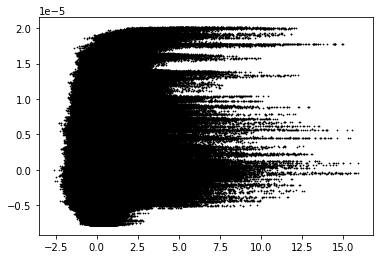

In [21]:
# How does surface precipitation scale as a function of twp?
fq=1e3
tPlot = np.arange(20,24)

for j in range(len(tPlot)):
    it = np.argmin(abs(tPlot[j]-time))
    twpp = np.ma.getdata(ds.variables['twp'][it,:,:])
    twpp -= np.mean(twpp)
    twppf = lowPass(twpp, circ_mask)
    
#     cm = np.ma.getdata(ds.variables['cldtop'][it,:,:])
    # cm = np.zeros(qli.shape)
    # cm[qli<qlc] = 0
    # cm[qli>=qlc] = 1
    surfprec = np.ma.getdata(ds.variables['surfprec'][it,:,:])
    surfprecpp = surfprec - np.mean(surfprec)
    surfprecppf = lowPass(surfprecpp, circ_mask)


    plt.scatter(twpp.flatten(),surfprecppf.flatten(),c='k',s=0.5)
plt.show()

## Forcing evolution plots for sst_hetero_x and qtpf

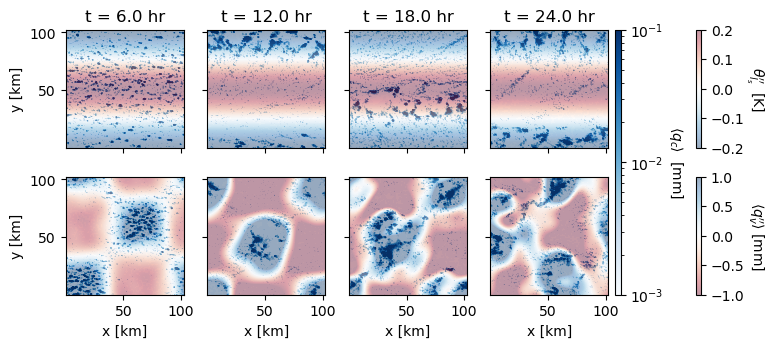

In [37]:
t0 = '2020-02-01 00:00:00'
t0 = datetime.datetime.strptime(t0,'%Y-%m-%d %H:%M:%S')
tPlot = np.linspace(6,24,4)

### ssthetero_x
lp = '/scratch-shared/janssens/eurec4a_balanced_100km_ssthetero_x'
sp = lp+'/figs'

ds = xr.open_dataset(lp+'/cape2d.001.nc')

extent = np.array([ds['xt'].min().values, ds['xt'].max().values, ds['xt'].min().values, ds['xt'].max().values])/1000

# SST pulse values
amppulse = 0.2 # 0.2 is approximately the difference between the moistest and driest half of eurec4a circles
kpulse = 1
itot = 1024
jtot = 1024
Lx = 1. # Set to specific value if it matters
Ly = 1.

# Pulse
dx = Lx/itot
dy = Ly/jtot

xf = np.arange(dx/2,Lx+dx/2,dx)
yf = np.arange(dy/2,Ly+dy/2,dy)

[Xf,Yf] = np.meshgrid(xf,yf,indexing='xy')

facx = 2*np.pi*kpulse
facy = 2*np.pi*kpulse

dthls = amppulse * np.cos(facy*Yf + np.pi) #* np.cos(facx*Xf + np.pi)

### qtpf
lp = '/scratch-shared/janssens/eurec4a_balanced_100km_qtpf'

dsq = xr.open_dataset(lp+'/cape2d.001.nc')

klp=4

circ_mask = np.zeros((dsq['xt'].size,dsq['xt'].size))
rad = getRad(circ_mask)
circ_mask[rad<=klp] = 1

fig,axs = plt.subplots(ncols=len(tPlot),nrows=2,figsize=(1.75*len(tPlot),1.75*2),
                       sharex=True,sharey=True,squeeze=False)

for j in range(len(tPlot)):

    # ssthetero_x
    lwp = ds['lwp'].sel(time=t0 + datetime.timedelta(hours=tPlot[j]), method='nearest')

    sc1 = axs[0,j].imshow(lwp , extent=extent,cmap='Blues', norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    sc0 = axs[0,j].imshow(dthls, extent=extent,cmap='RdBu_r', alpha=0.4, vmin=-amppulse, vmax=amppulse)
    
    # qtpf
    lwp = dsq['lwp'].sel(time=t0 + datetime.timedelta(hours=tPlot[j]), method='nearest')
    twp = dsq['twp'].sel(time=t0 + datetime.timedelta(hours=tPlot[j]), method='nearest')

    twp -= np.mean(twp)
    twpf = lowPass(twp.values, circ_mask)

    sc2 = axs[1,j].imshow(lwp , extent=extent,cmap='Blues', norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    sc3 = axs[1,j].imshow(twpf, extent=extent,cmap='RdBu', alpha=0.4, vmin=-1, vmax=1)

    axs[-1,j].set_xlabel('x [km]')
    axs[0,j].set_title('t = %.1f hr'%tPlot[j])
    if j == 0:
        for i in range(2):
            axs[i,j].set_ylabel('y [km]')
        
    if j == len(tPlot)-1:
        pos2 = axs[0,j].get_position()
        pos21 = axs[1,j].get_position()

        cbax = fig.add_axes([.91, pos21.ymin, 0.0075, pos2.ymax-pos21.ymin])
        cb = fig.colorbar(sc2, cax=cbax)
        cb.ax.set_ylabel(r"$\langle q_c\rangle$  [mm]", rotation=270, labelpad=15)

        cbax1 = fig.add_axes([1.025, pos2.ymin, 0.0075, pos2.ymax-pos2.ymin])
        cb1 = fig.colorbar(sc0, cax=cbax1)
        cb1.ax.set_ylabel(r"$\theta_{l_s}''$  [K]", rotation=270, labelpad=15)

        cbax2 = fig.add_axes([1.025, pos21.ymin, 0.0075, pos21.ymax-pos21.ymin])
        cb2 = fig.colorbar(sc3, cax=cbax2)
        cb2.ax.set_ylabel(r"$\langle q_{v}''\rangle $ [mm]", rotation=270, labelpad=15)
        
plt.savefig(sp+'/forced_lwp_evo.pdf', bbox_inches='tight',dpi=300)

In [6]:
tPlot

array([ 6., 12., 18., 24.])